In [188]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 

In [189]:
data = pd.read_parquet('./cs985-987-relevance-prediction-2024/relevance_train.parquet', engine='pyarrow')

In [190]:
data.shape

(19758, 10)

In [191]:
data.sample(5)

,doc_id,judgement,author,body,byline,title,topic_id,description,narrative,topic_title
3311,23a65b64-4f9c-11e3-9e2c-e1d01116fd98,0,— Leah Binkovitz,<p>THE DISTRICT</p>\n<p>Rail car catches firei...,By — Leah Binkovitz,Local digest: Rail car fire in D.C.; robberies,363,What disasters have occurred in tunnels used f...,A relevant document identifies a disaster in a...,transportation tunnel disasters
14145,177481b18f9fe5107ac5191635b41c60,0,Saad B. Omer,"<p>President-elect Donald Trump <a href=""https...",By Saad B. Omer,How Donald Trump’s conspiracy theories about v...,801,Find documents that describe religious objecti...,Religious beliefs have caused some groups in A...,Africa polio vaccination
18101,fc19e2ac9956d2db1ce49c11642a155f,0,Masha Gessen,<p>That video that everyone has seen but no on...,By Masha Gessen,Video captured Dzhokhar Tsarnaev moments befor...,808,Find documents that contain the verdict reache...,"To be relevant, a document must explicitly men...",Boston marathon bombing verdict
6344,873d0786-fe38-11e3-932c-0a55b81f48ce,1,None,<p>HEALTH CARE</p>\n<p>Firm recalculates part-...,None,Sodexo reverses itself after bumping cafeteria...,397,Identify documents that discuss the reasons fo...,A relevant document will specify major or mino...,automobile recalls
2827,44184352-d58d-11e5-a65b-587e721fb231,0,James McAuley,"<p><span class=""dateline"">CALAIS, France</span...",By James McAuley,Migrants in notorious French camp are spared e...,362,Identify incidents of human smuggling.,A relevant document shows an incident of human...,human smuggling


In [192]:
data['body'][0]

'<p>More than 60 years ago, a fair-skinned Irish politician\xa0named Sally Mulready was born into a home for unwed mothers called St. Patrick’s. It sat on a road named\xa0Navan in Dublin, and Mulready\xa0was one of four siblings born there. Her brother John never made it out of St. Pat’s. Like hundreds of other babies born into an Irish\xa0homes for “fallen women,” John\xa0died in 1947. He was two months old.</p>\\n<p>“Inanition,” his death record read, <a href="http://www.rte.ie/news/primetime/2014/0609/622696-prime-time-anatomy-of-a-scandal/">according to RTE News</a>. “Failure to thrive.”</p>\\n<p>But RTE News <a href="http://www.rte.ie/news/primetime/2014/0609/622696-prime-time-anatomy-of-a-scandal/">said</a>\xa0the\xa0record carried a mystery. John for some reason wasn’t buried until 1950 — three years after his death. The oddity was first discarded as a clerical error.</p>\\n<p>But it wasn’t. John’s records had\xa0the designation “AS,” or\xa0“anatomical study.” His infant remains

In [193]:
data['description'][1000]

'A relevant document would discuss the frequency of vicious black bear attacks worldwide and the possible causes for this savage behavior.'

In [194]:
data['narrative'][1000]

'It has been reported that food or cosmetics sometimes attract hungry black bears, causing them to viciously attack humans. \nRelevant documents would include the aforementioned causes as well as speculation preferably from the scientific community as to other possible causes of vicious attacks by black bears.\n A relevant document would also detail steps taken or new methods devised by wildlife officials to control and/or modify the savageness of the black bear.'

In [195]:
data['topic_title'][1000]

'Black Bear Attacks'

In [196]:
data['judgement'].value_counts(normalize=True).mul(100).round(3).astype(str) + '%'

0    84.285%
1    15.715%
Name: judgement, dtype: object

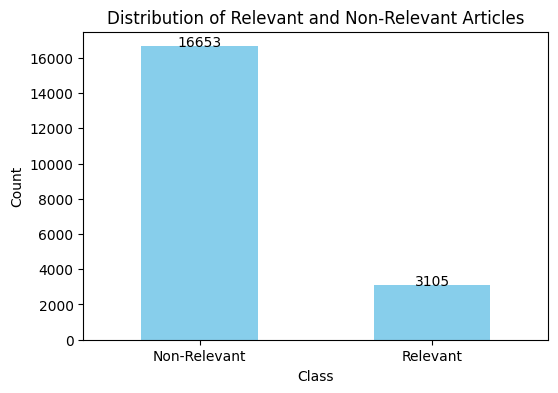

In [197]:
labels = {0: 'Non-Relevant', 1: 'Relevant'}
value_count = data['judgement'].map(labels).value_counts()

# Plotting
plt.figure(figsize=(6, 4))
bars = value_count.plot(kind='bar', color='skyblue')
plt.title('Distribution of Relevant and Non-Relevant Articles')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Relevant', 'Relevant'], rotation=0)
# plt.show()

# Annotating the bars with count values
for i, count in enumerate(value_count):
    bars.text(i, count + 0.1, str(count), ha='center')

plt.show()


There is an imbalance in the data with not relevant articles being 84% of the entire training data. That is, most of the articles are not relevant to the user's information need. We should keep this class imbalance in mind when interpreting the performance of the classification model. For time being, we will proceed with the data as it is and monitor the model performance with different parameters. 

In [198]:
data.isnull()
# data.isnull().values.any()

data.isnull().sum()

doc_id            0
judgement         0
author         1573
body             69
byline         1508
title             0
topic_id          0
description       0
narrative         0
topic_title       0
dtype: int64

In [199]:
data = data.dropna(subset=['body'])

In [200]:
data.drop(columns=['doc_id', 'topic_id', 'byline'], inplace=True)

In [201]:
data.tail(3)

,judgement,author,body,title,description,narrative,topic_title
26229,0,George F. Will,"<p><span class=""dateline"">URBANDALE, Iowa</spa...",Joni Ernst’s Iowa campaign makes quick work of...,Does diversion of U.S. corn crops into ethanol...,Identify documents that discuss the impact of ...,ethanol and food prices
26230,0,Daron Taylor,<p>There’s a secret history of bacon that almo...,The real reason why Americans love bacon for b...,Does diversion of U.S. corn crops into ethanol...,Identify documents that discuss the impact of ...,ethanol and food prices
26231,0,Becky Krystal,<p>You may have noticed that we’re focusing on...,"You’re all ears, and so are we: Our favorite c...",Does diversion of U.S. corn crops into ethanol...,Identify documents that discuss the impact of ...,ethanol and food prices


In [202]:
data['author'].nunique()

3363

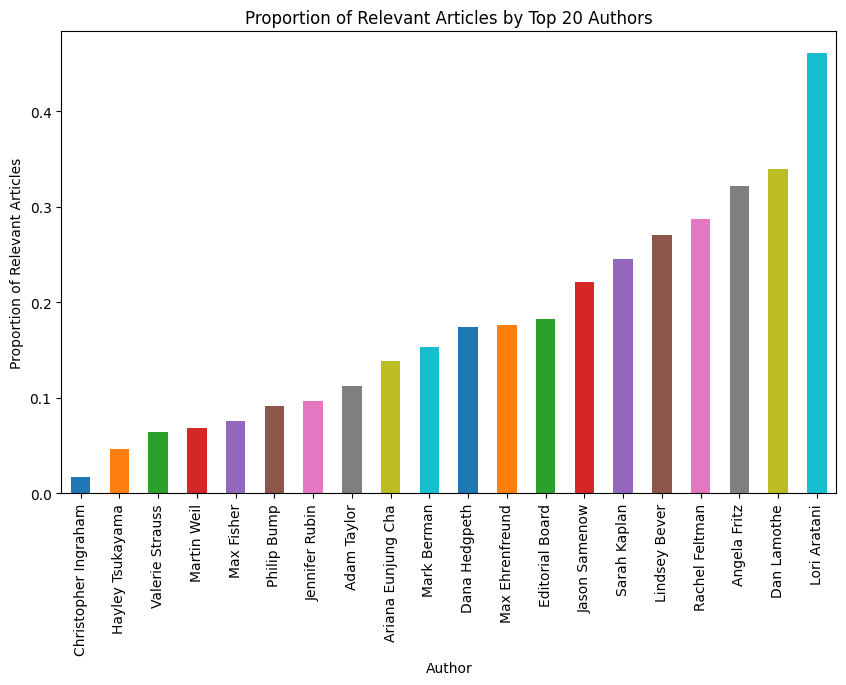

In [203]:

top_20_authors = data['author'].value_counts().nlargest(20).index
authors = data[data['author'].isin(top_20_authors)]

author_relevance = authors.groupby('author')['judgement'].mean().sort_values()

colors = sns.color_palette('tab10', len(author_relevance))

plt.figure(figsize=(10, 6))
author_relevance.plot(kind='bar', color=colors)
plt.title('Proportion of Relevant Articles by Top 20 Authors')
plt.xlabel('Author')
plt.ylabel('Proportion of Relevant Articles')
plt.xticks(rotation=90)
plt.show()


The plot represents the proportion of relevant articles authored by top 20 authors from the training data. There are 3365 unique artists present in the training data, therefore we plot the graph for only top 20 authors to increase readability.

### Text Cleaning

The process involves removing html tags from the body columns, tokenisation, lower casing, removing stop words, puncuation markers etc. and vectorization. However, processes such as stemming or lemmatization can be used. Here, we are performing the following steps: removing `<p>` and other tag, puncuation, numbers, and stopwords. 

In [204]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

def text_cleaning(text):
    
    # Remove html tags using BeautifulSoup
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Tokenize the text into words
    tokens = word_tokenize(text)

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Perform stemming using Porter Stemmer algorithm
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    # Join the tokens back into a single string
    processed_text = ' '.join(stemmed_tokens)

    return processed_text

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/visheshkishore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/visheshkishore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [205]:
data['body'][0] = text_cleaning(data['body'][0])

/var/folders/m_/d9ytr15j7xs96j0pg4x6z7dm0000gn/T/ipykernel_2009/3294494906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['body'][0] = text_cleaning(data['body'][0])


#### WordCloud to Analyize article relevance

In [206]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloud(text):

    # Generate a word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


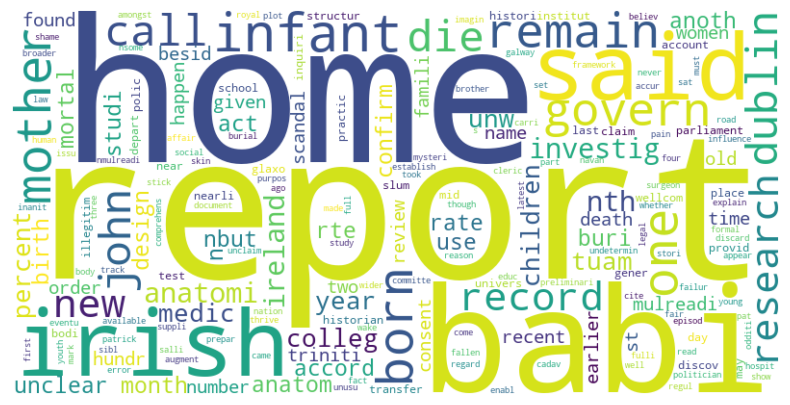

In [207]:
wordcloud(data['body'][0])

In [208]:
data['body'][0]

'60 year ago fair-skin irish politician name salli mulreadi born home unw mother call st. patrick ’ sat road name navan dublin mulreadi one four sibl born brother john never made st. pat ’ like hundr babi born irish home “ fallen women ” john die 1947 two month old.\\n “ inanit ” death record read accord rte new “ failur thrive. ” \\nbut rte new said record carri mysteri john reason ’ buri 1950 — three year death odditi first discard cleric error.\\nbut ’ john ’ record design “ ” “ anatom study. ” infant remain fact given research triniti colleg dublin use medic research — though ’ unclear whether mother given consent this.\\nmulreadi eventu track burial plot explain irish time found mark “ stick number … imagin happen children young babi die … well-to-do-famili famili influence. ” \\nbut happen babi besid john accord recent irish govern report confirm augment earlier report rte investig call “ anatomi scandal.\\nth report preliminari review design set framework full formal investig or

In [209]:
data['description'][0]

'Pertinent documents will reflect the fact that women continue to be poorly represented in parliaments across the world, and the gap in political power between the sexes is very wide, particularly in the Third World.'

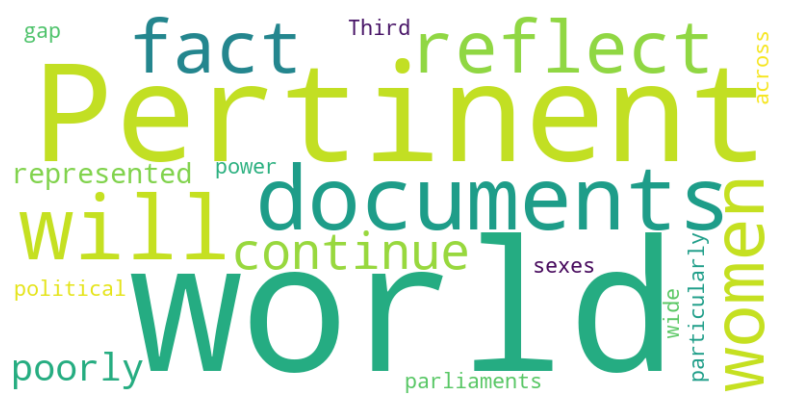

In [210]:
wordcloud(data['description'][0])

The process of removing html tags from body, lower casing, removing stopwords and stemming is applied on 1st instance of the training dataset via text_cleaning function. Furthermore, wordcloud for the same instance was plotted. It is observed from the wordcloud that the user's information need (description) do not seem relevant to the content of the article (body). As seen from the content of the wordcloud, the article somehow seems something related to Ireland whereas the description revolves aroung Woman in Parliament. Conclusively, the article is not relevant (judgement) feature.

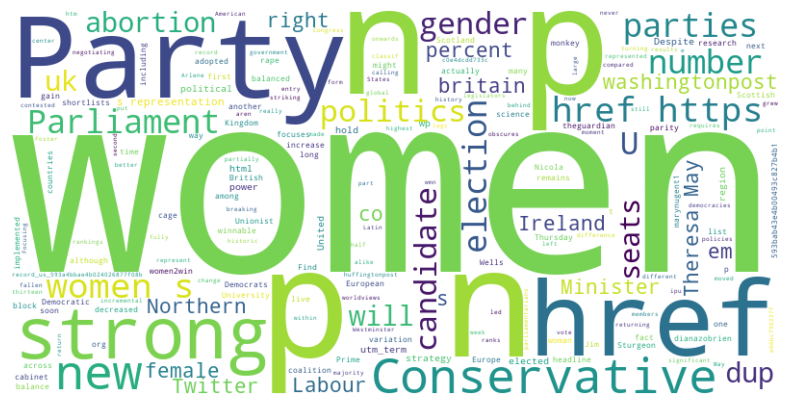

In [211]:
wordcloud(data['body'][6])

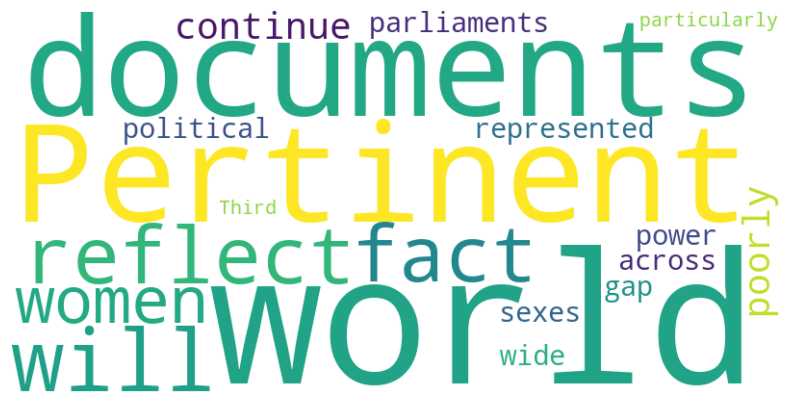

In [212]:
wordcloud(data['description'][6])

It can be observed from the wordcloud plot above that the content of the article (body) contains words that seem relevant to user's information need (description). The article is somewhat related about political elections and the description of the also represents the same. 

It can be concluded that wordcloud gave us qualitative understanding of the language used in relevant and non-relevant articles.

### Applying Text Cleaning function on training dataset

In [213]:
data['body'].isnull().any()

False

In [214]:
data.columns

Index(['judgement', 'author', 'body', 'title', 'description', 'narrative',
       'topic_title'],
      dtype='object')

In [215]:
# Applying text cleaning function to each column of the training dataset
data[['body', 'title', 'description', 'narrative']] = data[['body', 'title', 'description', 'narrative']].applymap(text_cleaning)

/var/folders/m_/d9ytr15j7xs96j0pg4x6z7dm0000gn/T/ipykernel_2009/1969535462.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [225]:
data['combined_text'] = data['body'] + data['description'] + data['narrative'] + data['title']

In [226]:
data.head(3)

,judgement,author,body,title,description,narrative,topic_title,combined_text
0,0,Terrence McCoy,60 year ago fair-skin irish politician name sa...,report irish babi home document use infant med...,pertin document reflect fact women continu poo...,pertin document relat issu discuss lack repres...,Women in Parliaments,60 year ago fair-skin irish politician name sa...
1,0,Brian McNoldy,hurrican fred form weekend far eastern atlant ...,hurrican fred fountain ‘ first ’ atlant ocean,pertin document reflect fact women continu poo...,pertin document relat issu discuss lack repres...,Women in Parliaments,hurrican fred form weekend far eastern atlant ...
2,0,Editorial Board,eight year ago month inspir movement took hold...,ukrain slide away democraci,pertin document reflect fact women continu poo...,pertin document relat issu discuss lack repres...,Women in Parliaments,eight year ago month inspir movement took hold...


In [227]:
data['combined_text'][0]

'60 year ago fair-skin irish politician name salli mulreadi born home unw mother call st. patrick ’ sat road name navan dublin mulreadi one four sibl born brother john never made st. pat ’ like hundr babi born irish home “ fallen women ” john die 1947 two month old.\\n “ inanit ” death record read accord rte new “ failur thrive ” \\nbut rte new said record carri mysteri john reason ’ buri 1950 — three year death odditi first discard cleric error.\\nbut ’ john ’ record design “ ” “ anatom studi ” infant remain fact given research triniti colleg dublin use medic research — though ’ unclear whether mother given consent this.\\nmulreadi eventu track burial plot explain irish time found mark “ stick number … imagin happen children young babi die … well-to-do-famili famili influenc ” \\nbut happen babi besid john accord recent irish govern report confirm augment earlier report rte investig call “ anatomi scandal.\\nth report preliminari review design set framework full formal investig order 

In [228]:
# Combining columns into a single column 'combined_text'
data_new = data[['combined_text', 'judgement']].copy()

In [229]:
data_new.sample(5)

,combined_text,judgement
4460,democrat vice-presidenti nomine sen. tim kain ...,0
20434,’ half centuri hemp back sort of.\nearli month...,0
14354,staff report news servic \nlago nigeria — nige...,0
11232,past two decad scientist politician conserv ac...,1
21705,standard argument — realli argument — rais min...,0


### Performing TF-IDF Vectorizer

In [230]:
articles = list(data_new['combined_text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(articles)
articles = tfidf_vectorizer_vectors.toarray()

### Separating features and target variables

In [231]:
X = articles 
Y = data['judgement']

In [232]:
print(X.shape, Y.shape)

(19689, 20000) (19689,)


In [233]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(13782, 20000) (13782,)
(5907, 20000) (5907,)


### 1. Applying Machine Learning Baseline Models

#### Stochastic Gradient Descent

In [234]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

lr_clf = SGDClassifier(loss='log_loss', random_state=42)
lr_clf.fit(X_train, Y_train)

y_pred_train = lr_clf.predict(X_train)
y_pred_test = lr_clf.predict(X_val)

print("\nTraining Accuracy score:",accuracy_score(Y_train, y_pred_train))
print("Validation Accuracy score:",accuracy_score(Y_val, y_pred_test))

print("\nTraining precision score:",precision_score(Y_train, y_pred_train))
print("Validation precision score:",precision_score(Y_val, y_pred_test))



Training Accuracy score: 0.8822377013495865
Validation Accuracy score: 0.8684611477907568

Training precision score: 0.9047619047619048
Validation precision score: 0.8361344537815126


### 2. Three layer Neural Network Baseline Model

In [235]:
X.shape

(19689, 20000)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def three_layer_nn(neurons):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(20000,), activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['precision'])
    return model

    

In [237]:
list_of_neurons = [100, 250, 500, 1000]

precisions = []

for neurons in list_of_neurons:
    print(f'\nTraining model with {neurons} neurons in hidden layer')
    model = three_layer_nn(neurons)
    model.fit(X_train, Y_train, epochs=10, batch_size=100)
    _, precision = model.evaluate(X_train, Y_train)
    precisions.append(precision)

    print('Precision: %.2f' % (precision*100))




Training model with 100 neurons in hidden layer


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4814 - precision: 0.2329
Epoch 2/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2570 - precision: 0.8321
Epoch 3/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1108 - precision: 0.9068
Epoch 4/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0499 - precision: 0.9530
Epoch 5/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0285 - precision: 0.9773
Epoch 6/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0201 - precision: 0.9825
Epoch 7/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0172 - precision: 0.9823
Epoch 8/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0144 - precision: 0.9889
Epoch 9/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0109 - precision: 0.9906
Epoch 10/10
138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0104 - precision: 0.9906
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068 - precision: 0.9897
Precision: 98.76

Training model with 250 ne

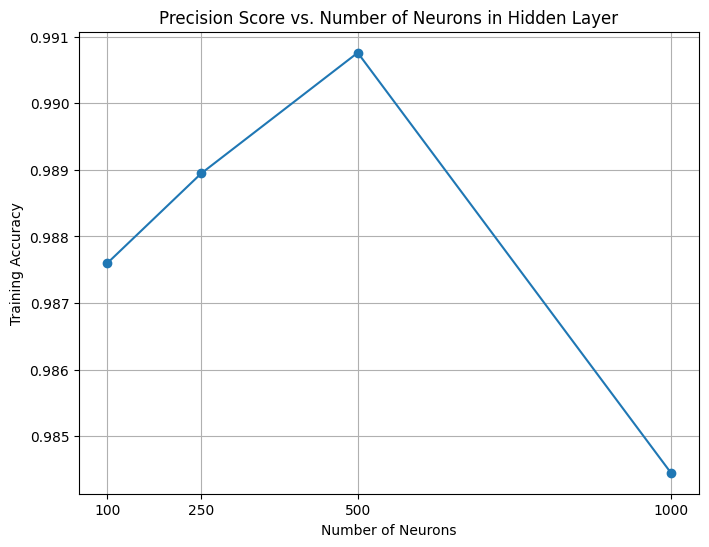

In [238]:
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(list_of_neurons, precisions, marker='o')
plt.title('Precision Score vs. Number of Neurons in Hidden Layer')
plt.xlabel('Number of Neurons')
plt.ylabel('Training Accuracy')
plt.xticks(list_of_neurons)
plt.grid(True)
plt.show()

In [310]:
model = Sequential()
model.add(Dense(1000, input_shape=(20000,), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['precision'])
model.fit(X, Y, epochs=10, batch_size=1000)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 242s 12s/step - loss: 0.4768 - precision: 0.0633
Epoch 2/10


In [240]:
_, precision = model.evaluate(X_val, Y_val)

185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0075 - precision: 0.9883


In [241]:
print(model.summary())

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_144 (Dense)               │ (None, 500)            │    10,000,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,152,105 (115.02 MB)

 Trainable params: 10,050,701 (38.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,101,404 (76.68 MB)

None


### Pre-Processing the Test Dataset

In [242]:
test_data = pd.read_parquet('./cs985-987-relevance-prediction-2024/relevance_test.parquet')

In [243]:
test_data.shape

(4884, 9)

In [244]:
test_data.head(3)

,doc_id,author,body,byline,title,topic_id,description,narrative,topic_title
2050,0002e4f816c863e4b912d6d97dcb68ad,Max Bearak,<p>The United Nations Human Rights Committee <...,By Max Bearak,A U.N. judgment says Ireland’s anti-abortion l...,350,Is it hazardous to the health of individuals t...,Relevant documents would contain any informati...,Health and Computer Terminals
2051,000c86ea-55df-11e2-bf3e-76c0a789346f,Simson Garfinkel,"<p>In January 1976, Ray Kurzweil introduced th...",By Simson Garfinkel,‘How to Create a Mind: The Secret of Human Tho...,350,Is it hazardous to the health of individuals t...,Relevant documents would contain any informati...,Health and Computer Terminals
2052,001b27476dfbcdd1431b1607419d83af,Burke Balch,"<p><strong><em>Each week, </em><a href=""http:/...",By Burke Balch,Why are we more interested in pushing death th...,350,Is it hazardous to the health of individuals t...,Relevant documents would contain any informati...,Health and Computer Terminals


In [245]:
test_data.isnull().any()

doc_id         False
author          True
body            True
byline          True
title          False
topic_id       False
description    False
narrative      False
topic_title    False
dtype: bool

In [246]:
# test_data = test_data.dropna(subset=['author', 'body', 'byline'])
import random
import string

# Function to generate random text
def generate_random_text(length):
    return ''.join(random.choices(string.ascii_letters + string.digits, k=length))

# Assuming 'df' is your DataFrame and 'text_columns' is a list of text columns
text_columns = ['author', 'body', 'byline']

for column in text_columns:
    test_data[column] = test_data[column].fillna(generate_random_text(50))  # Replace '50' with desired length of random text



In [247]:
test_data.head(3)

,doc_id,author,body,byline,title,topic_id,description,narrative,topic_title
2050,0002e4f816c863e4b912d6d97dcb68ad,Max Bearak,<p>The United Nations Human Rights Committee <...,By Max Bearak,A U.N. judgment says Ireland’s anti-abortion l...,350,Is it hazardous to the health of individuals t...,Relevant documents would contain any informati...,Health and Computer Terminals
2051,000c86ea-55df-11e2-bf3e-76c0a789346f,Simson Garfinkel,"<p>In January 1976, Ray Kurzweil introduced th...",By Simson Garfinkel,‘How to Create a Mind: The Secret of Human Tho...,350,Is it hazardous to the health of individuals t...,Relevant documents would contain any informati...,Health and Computer Terminals
2052,001b27476dfbcdd1431b1607419d83af,Burke Balch,"<p><strong><em>Each week, </em><a href=""http:/...",By Burke Balch,Why are we more interested in pushing death th...,350,Is it hazardous to the health of individuals t...,Relevant documents would contain any informati...,Health and Computer Terminals


In [248]:
# Applying text cleaning function to each column of the training dataset
test_data[['body', 'title', 'description', 'narrative']] = test_data[['body', 'title', 'description', 'narrative']].applymap(text_cleaning)

/var/folders/m_/d9ytr15j7xs96j0pg4x6z7dm0000gn/T/ipykernel_2009/1969535462.py:15: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [249]:
test_data['combined_text'] = test_data['body'] + test_data['description'] + test_data['narrative'] + test_data['title']

In [250]:
test_data.head()

,doc_id,author,body,byline,title,topic_id,description,narrative,topic_title,combined_text
2050,0002e4f816c863e4b912d6d97dcb68ad,Max Bearak,unit nation human right committe announc rule ...,By Max Bearak,u.n. judgment say ireland ’ anti-abort law vio...,350,hazard health individu work comput termin dail...,relev document would contain inform expand phy...,Health and Computer Terminals,unit nation human right committe announc rule ...
2051,000c86ea-55df-11e2-bf3e-76c0a789346f,Simson Garfinkel,januari 1976 ray kurzweil introduc kurzweil re...,By Simson Garfinkel,‘ creat mind secret human thought reveal ’ ray...,350,hazard health individu work comput termin dail...,relev document would contain inform expand phy...,Health and Computer Terminals,januari 1976 ray kurzweil introduc kurzweil re...
2052,001b27476dfbcdd1431b1607419d83af,Burke Balch,week theori take big idea news explor rang per...,By Burke Balch,interest push death improv life,350,hazard health individu work comput termin dail...,relev document would contain inform expand phy...,Health and Computer Terminals,week theori take big idea news explor rang per...
2053,001eb05a-719e-11e3-8b3f-b1666705ca3b,Juliet Eilperin; Amy Goldstein,obama administr decid jettison healthcare.gov ...,By Juliet Eilperin and Amy Goldstein,obama administr end contract cgi feder compani...,350,hazard health individu work comput termin dail...,relev document would contain inform expand phy...,Health and Computer Terminals,obama administr decid jettison healthcare.gov ...
2054,0058b29067c414f21b35c8f64cb49e64,Ariana Eunjung Cha,adolesc year peopl 's bodi suppos start ascent...,By Ariana Eunjung Cha,teenag sedentari 60-year-old age 19,350,hazard health individu work comput termin dail...,relev document would contain inform expand phy...,Health and Computer Terminals,adolesc year peopl 's bodi suppos start ascent...


### Performing TF-IDF 

In [251]:
articles_test = list(test_data['combined_text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(articles_test)
articles_test = tfidf_vectorizer_vectors.toarray()

In [252]:
articles_test

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01968212, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.01668843, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Model Training on Whole Training Data
In order to validate our models, split the training dataset into training and validation set. To use actual test dataset which is completely unseen during training, models were trained on entire training set rather than just a subset of training set.

In [253]:
sgd_clf = SGDClassifier(loss='log_loss', random_state=42)
sgd_clf.fit(X, Y)

SGDClassifier(loss='log_loss', random_state=42)

In [254]:
X_test = articles_test

In [261]:
# Fitting the model on test dataset
test_pred = sgd_clf.predict(X_test)

In [1]:
# Fitting with 3 layer NN
y_pred_prob = model.predict(X_test).flatten()
binary_pred = np.where(y_pred_prob >= 0.4, 1, 0)

NameError: name 'model' is not defined

In [306]:
y_pred_prob

array([2.7669249e-11, 7.1979425e-06, 3.2628489e-10, ..., 6.0255818e-09,
       3.4206787e-12, 9.8962255e-13], dtype=float32)

In [307]:
# Creating dataframe of Id and judgement for kaggle submission
test_pred_df = pd.DataFrame({'id': test_data['doc_id'], 'judgement': binary_pred.reshape(-1)})
print(test_pred_df)

                                         id  judgement
2050       0002e4f816c863e4b912d6d97dcb68ad          0
2051   000c86ea-55df-11e2-bf3e-76c0a789346f          0
2052       001b27476dfbcdd1431b1607419d83af          0
2053   001eb05a-719e-11e3-8b3f-b1666705ca3b          0
2054       0058b29067c414f21b35c8f64cb49e64          0
...                                     ...        ...
24957      fe097e53be7e8feec1ef4ffdf9f54c4f          0
24958      fec727ff7c20faa1bb65d664cc459c59          0
24959      ff4c7b7a86185b580010f20fad44a6d5          0
24960  ffc37f8c-8885-11e4-9534-f79a23c40e6c          0
24961      fffc88ac6c905b50636aa9052e0010f7          0

[4884 rows x 2 columns]


In [308]:
test_pred_df[test_pred_df['judgement'] == 1]

,id,judgement
10097,19a7e962-68fb-11e2-9a0b-db931670f35d,1
16048,c57e6284-284b-11e2-bab2-eda299503684,1
16192,fa8d51e57fd32e6e101d4acf5998c8b7,1


In [288]:
# Converting dataframe to csv
test_pred_df.to_csv('relevance_prediction.csv', index=False)